# imports

In [1]:
from functions import *

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
plt.style.use('fivethirtyeight')
#sns.set()
#pd.options.display.max_columns = 100

# PART 1 : USE MAIN CSV FILE

# Read MAIN Data

In [2]:
# Training data
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis and Preprocessing

In [3]:
# examine distribution of the TARGET
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### note that we have imbalanced classes

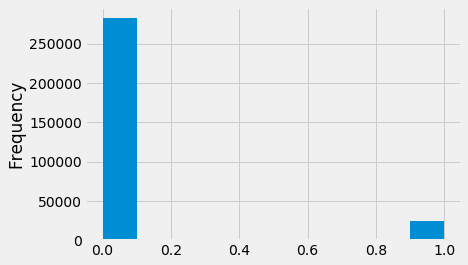

In [4]:
# visualize the imbalance
app_train['TARGET'].astype(int).plot.hist();

In [5]:
# missing values 
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Missing Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


##### note that XGboost can handle missing values with no need for imputation

In [6]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### Most of the categorical variables have a relatively small number of unique entries.

In [8]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)

print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 246)


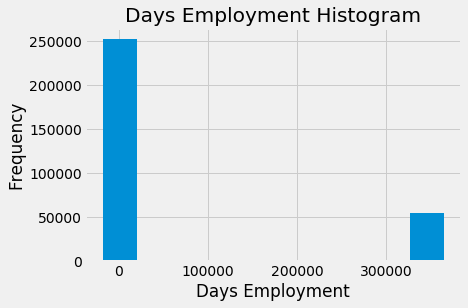

In [9]:
# try to find anomalies in the data 
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

#### That doesn't look right! The maximum value is about 1000 years

In [10]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The mean of the TARGET for non_anom clients %f' % (non_anom['TARGET'].mean()))
print('The mean of the TARGET for anom clients %f' % (anom['TARGET'].mean()))


The mean of the TARGET for non_anom clients 0.086600
The mean of the TARGET for anom clients 0.053996


#### Just to remember TARGET = 0 means repayed on time, 1 means it mean have difficulty

In [11]:
# Find correlations with the TARGET
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

#### DAYS_BIRTH is the age in days of the client at the time of the loan in negative days 

In [12]:
# since the age is negative we need to Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

#### as clients get older, they tend to repay their loans on time more often.

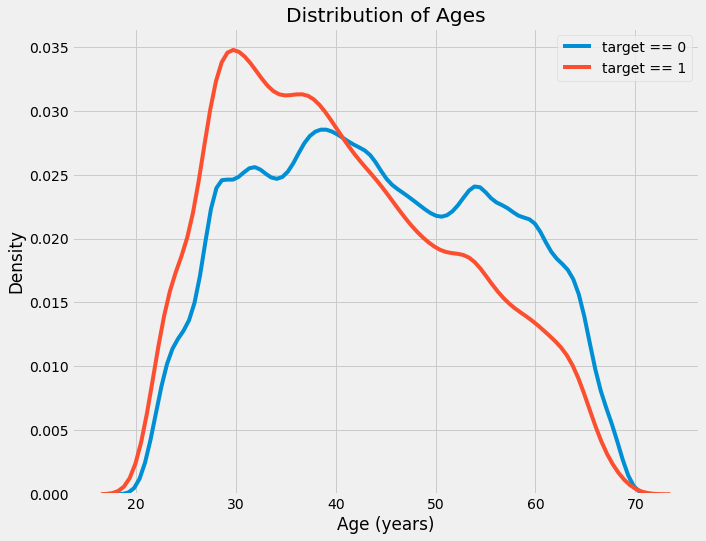

In [13]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

### take deep dive on how age affect repayment 

In [14]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [15]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


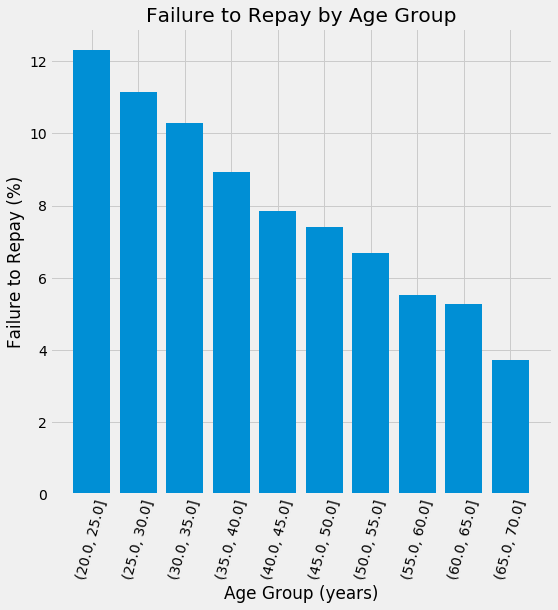

In [16]:
#plot age groups VS Failure Repay %
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

#### There is a clear trend: younger applicants are more likely to not repay the loan

### Exterior Sources

#### The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data

In [17]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


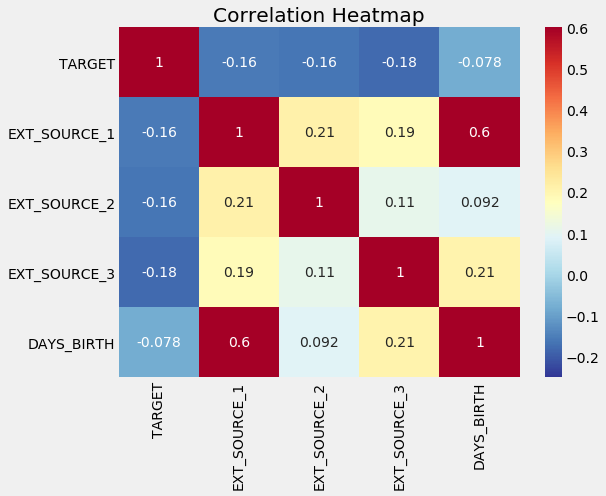

In [18]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

#### All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

### Pairs Plot (EXT_SOURCE vars and DAYS_BIRTH var)

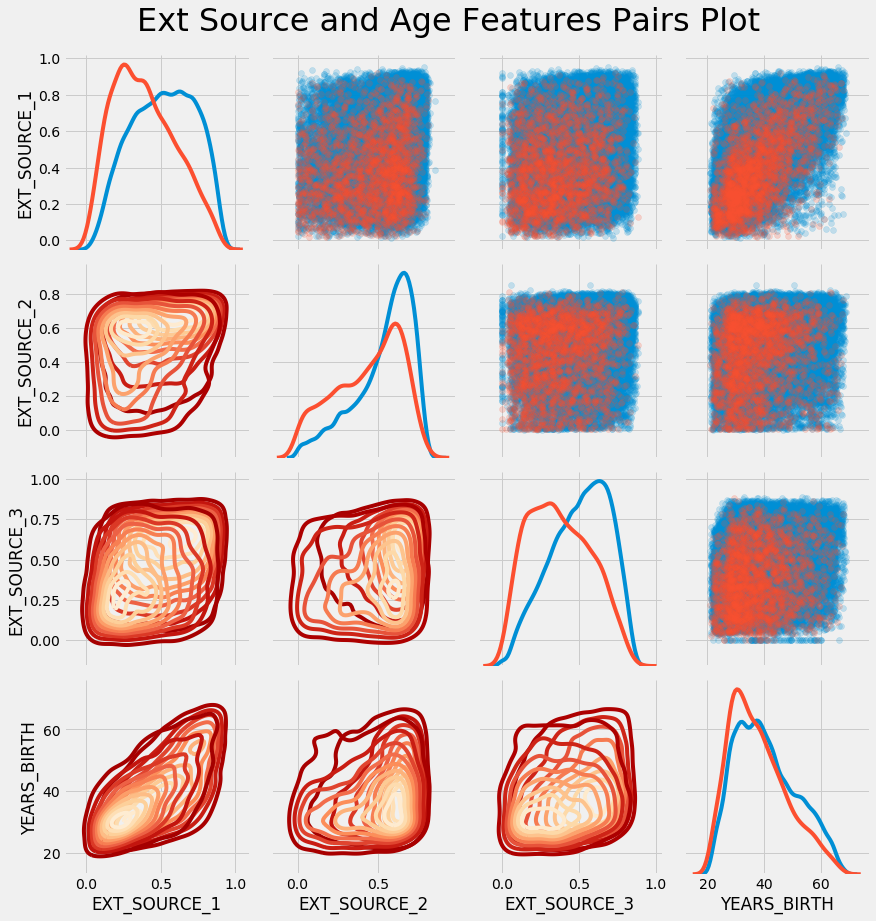

In [19]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Feature Engineering
## Polynomial features

In [20]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]


# imputer for handling missing values

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

#----------------------------------------------------------------
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

Polynomial Features shape:  (307511, 35)


In [21]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [22]:
# we want to see if these new features are correlated to the TARGET
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


#### Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

In [23]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = ['SK_ID_CURR','TARGET'], how = 'inner')
print('Training data with polynomial features shape: ', app_train_poly.shape)

Training data with polynomial features shape:  (307511, 281)


## Domain knowledge features

In [24]:
# create new feature related to the domain
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

#### It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

# PART 1 END: MASTER DATAFRAME

In [25]:
master_df = app_train_domain.merge(poly_features, how='left')
master_df.head()
master_df.shape

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(307511, 281)

# PART 2 
# Read Bureau

In [26]:
# Read in bureau
bureau = pd.read_csv('data/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [27]:
bureau.shape

(1716428, 17)

#### bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
#### bureau_balance: monthly information about the previous loans. Each month has its own row.

In [28]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [29]:
# Join the Master data frame
master_df1 = master_df.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
master_df1['previous_loan_counts'] = master_df1['previous_loan_counts'].fillna(0)
master_df1.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,previous_loan_counts
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,8.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


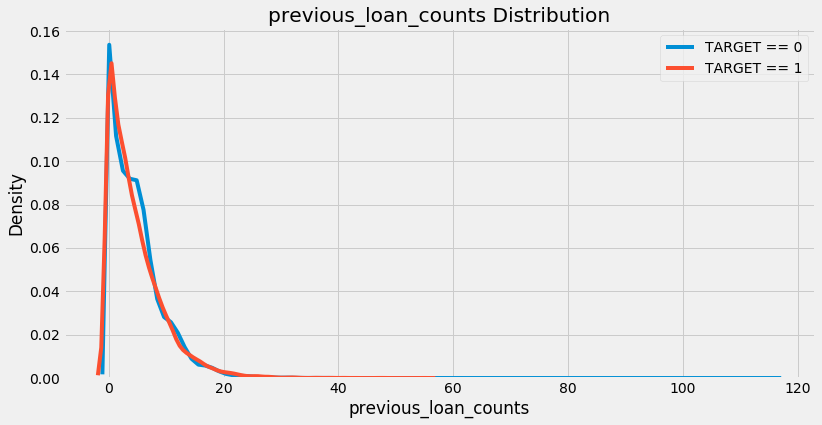

In [30]:
# can we get informations from the new value ?
kde_target('previous_loan_counts', master_df1)

#### From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions.

### Aggregating Numeric Columns

In [31]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [32]:
# Reduce to SINGLE level index 
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,index,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [33]:
# Now we can simply MERGE with Master datafarme

master_df2 = master_df1.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
master_df2.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Categorical variables

In [34]:
# select categorical varialbes
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [35]:
# groupby to get each unique ID
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [36]:
# Reduce to SINGLE level index 
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,SK_ID_CURR,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [37]:
# Merge with MASTER dataframe
master_df3 = master_df2.merge(bureau_counts,on='SK_ID_CURR', how='left')
master_df3.head()
master_df3.shape

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(307511, 389)

# PART 3
# Read Bureau_balance csv

In [38]:
bureau_balance = pd.read_csv('data/bureau_balance.csv')
bureau_balance.head()
bureau_balance.shape

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


(27299925, 3)

In [39]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
uint8_columns = list(bureau_balance_counts.select_dtypes('uint8').columns.tolist())
bureau_balance_counts_uint8 = bureau_balance_counts.select_dtypes('uint8').astype(int).copy()
bureau_balance_counts.drop(uint8_columns, axis=1,inplace=True)
bureau_balance_counts = bureau_balance_counts.merge(bureau_balance_counts_uint8, left_index=True, right_index=True)
bureau_balance_counts.head()
bureau_balance_counts.shape

,SK_ID_BUREAU,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count_norm,bureau_balance_STATUS_0_count,bureau_balance_STATUS_1_count,bureau_balance_STATUS_2_count,bureau_balance_STATUS_3_count,bureau_balance_STATUS_4_count,bureau_balance_STATUS_5_count,bureau_balance_STATUS_C_count,bureau_balance_STATUS_X_count
0,5001709,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0,0,0,0,0,0,86,11
1,5001710,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,5,0,0,0,0,0,48,30
2,5001711,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,3,0,0,0,0,0,0,1
3,5001712,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,10,0,0,0,0,0,9,0
4,5001713,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0,0,0,0,0,0,0,22


(817395, 17)

In [40]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.drop('index', axis=1, inplace=True)
bureau_balance_agg.head()
bureau_balance_agg.shape

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


(817395, 6)

In [41]:
# Dataframe grouped by the loan

bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, on='SK_ID_BUREAU', how = 'inner')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

# filter by clients
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

bureau_balance_by_client.head()
bureau_balance_by_client.shape

,index,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,...,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum
0,0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,...,7,15.714286,44,0,110,7,4.285714,9,0,30
1,1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,...,8,2.875000,13,0,23,8,1.875000,3,0,15
2,2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,...,3,1.666667,5,0,5,3,0.666667,1,0,2
3,3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,...,2,26.000000,26,26,52,2,0.000000,0,0,0
4,4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,...,4,25.750000,44,0,103,4,10.250000,40,0,41


(134542, 107)

In [42]:
# MERGE with Master dataframe
master_df4 = master_df3.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')
master_df4

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,8.0,2.875000,13.0,0.0,23.0,8.0,1.875000,3.0,0.0,15.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,9327,-236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,20775,365243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,14966,-7921,...,4.0,14.250000,19.0,0.0,57.0,4.0,3.250000,13.0,0.0,13.0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,11961,-4786,...,1.0,29.000000,29.0,29.0,29.0,1.0,0.000000,0.0,0.0,0.0


In [43]:
master_df.shape
master_df1.shape
master_df2.shape
master_df3.shape
master_df4.shape

(307511, 281)

(307511, 282)

(307511, 343)

(307511, 389)

(307511, 495)

In [44]:
# Free up memory by deleting old objects
import gc
gc.enable()
del master_df,master_df1,master_df2,master_df3, bureau, bureau_balance, bureau_agg, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_counts
gc.collect()

3058

In [45]:
missing_df = missing_values_table(master_df4)
missing_df

Your selected dataframe has 495 columns.
There are 307 columns that have missing values.


,Missing Values,% of Total Missing Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
client_bureau_balance_STATUS_X_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_norm_sum,215280,70.0
...,...,...
CREDIT_TERM,12,0.0
ANNUITY_INCOME_PERCENT,12,0.0
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [46]:
#we will remove any columns in data that have greater than 90% missing values.
missing_train_vars = list(missing_df.index[missing_df['% of Total Missing Values'] > 90])
master_df4.drop(missing_train_vars, axis=1, inplace=True)

In [47]:
missing_train_vars

[]

In [48]:
missing_values_table(master_df4)

Your selected dataframe has 495 columns.
There are 307 columns that have missing values.


,Missing Values,% of Total Missing Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
client_bureau_balance_STATUS_X_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_norm_sum,215280,70.0
...,...,...
CREDIT_TERM,12,0.0
ANNUITY_INCOME_PERCENT,12,0.0
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0
